In [1]:
import io
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import time
import scipy
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader
import torch
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
import torch.optim as optim
from torch import device

In [2]:
import os
os.chdir('drive/MyDrive/PSL/Project/Project 2')

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Generator(nn.Module):
    
    """
      This defines the model that takes as input an embedding from the source language X
      and outputs an embedding W @ X supposed to be close to the the target language (its translation)
      This model is a 300 x 300 matrice, represented by the linear layer W. 

      args : 
          - beta : beta parameter for orthogonalization of W
    """

    def __init__(self, beta = 0.01):
        super().__init__()
        self.W = nn.Linear(300, 300, bias=False)
        self.beta = beta

    def forward(self, x):
        return self.W(x)
    
    """
    Forcing an orthogonalize constraint on W improves the accuracy of the prediction
    """
    def orthogonalize(self):
        W = self.W.weight.data
        W_ortho = (1 + self.beta) * W - self.beta * W.mm(W.transpose(0,1).mm(W))
        self.W.weight.data = W.copy_(W_ortho)

    """
    Used for refinement. We use the surest predictions that W has made to recompute W using Procrustes solution on those predictions.
    This way, it closes together the surest predictions, and with them the other predictions to give better accuracy.  
    
    args :
        - target_embeddings : Y embeddings from the target language
        - predicted_embeddings : W @ X  with X embeddings from the source language
        - similar_pairs : pair of words (source, target) that W would pair together (according to cosine similarity)
    """
    def procrustes(self, predicted_embeddings, target_embeddings, similar_pairs):
        A = predicted_embeddings[similar_pairs[:,0]]
        B = target_embeddings[similar_pairs[:,1]]
        U, S, V_t = scipy.linalg.svd(B.T.dot(A), full_matrices=True)
        self.W.weight.data.copy_(torch.tensor(U.dot(V_t)).type_as(self.W.weight.data))


class Discriminator(nn.Module):
    """
      This defines the model that takes as input embeddings from the target language Y,
      or generated embeddings from the source language W @ X.
      This model uses frequent dropouts and 2 hidden layers of 2048 x 2048 to have better accuracy.
      It should output a single value after a sigmoid activation : 
        - 1 if the model thinks the embedding is from Y
        - 0 if the model thinks the embedding is from W @ X
    """

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(300, 2048),
            nn.Dropout(0.1),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 2048),
            nn.Dropout(0.1),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 2048),
            nn.Dropout(0.1),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 1),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x).reshape(-1)

In [27]:
class GAN():

    def __init__(self, src_path, tgt_path, test_path, epochs=40, batch_size=32, lr=0.1, decay=0.98, beta=0.01):
        """
        Defines the adversarial GAN and the methods to train and test it.
        
        args :
            - src_path       path to the .vec file with the embeddings of the source language
            - tgt_path       path to the .vec file with the embeddings of the target language
            - test_path      path to the .txt file with the set of translations of the test set
            - epochs         number of epochs to train on
            - batch_size     batch size to train on 
            - lr             learning rate to start off with 
            - decay          decay of the learning rate at each epoch 
            - beta           beta parameter to orthogonalize the generator at each step
        """

        ### LOADING THE DATA

        # We load a maximum amount of embeddings at first (200k) to ensure we will have all the embeddings of the test set 
        self.src_embeddings, self.src_id2word, self.src_word2id = self.load_vec(src_path)
        self.targ_embeddings, self.targ_id2word, self.targ_word2id = self.load_vec(tgt_path)
        
        self.epochs, self.batch_size = epochs, batch_size
        
        # We load the test set and store the embeddings in test_source_embeddings and test_target_embeddings (their indices are alined)
        self.df_test = pd.read_csv(test_path, sep=" ", header = None, na_filter=False, error_bad_lines=False)     # Sometimes the separator is '\t' 
        self.dico_test = {}
        self.test_source_embeddings, self.test_target_embeddings = [], []
        self.load_data()
        
        # We reduce the dataset to the first 50000 embeddings otherwise the training is too long
        self.src_embeddings, self.targ_embeddings = self.src_embeddings[:50000, :], self.targ_embeddings[:50000, :]


        ### MODEL DEFINITION
        self.generator = Generator(beta).to(device)
        self.discriminator = Discriminator().to(device)
        
        # Here we store the best generator according to accuracy on the test set, to select our best epoch
        self.best_W = None
        self.best_accuracy = 0

        # Optimisation parameters and learning rate decays for each model 
        self.BCE = nn.BCELoss()
        self.optim_discri = optim.SGD(self.discriminator.parameters(), lr=lr)
        self.optim_gen = optim.SGD(self.generator.parameters(), lr=lr)
        self.lr_decay_discri = StepLR(self.optim_discri, step_size=1, gamma=decay)
        self.lr_decay_gen = StepLR(self.optim_gen, step_size=1, gamma=decay)

        ### DATA
        self.X = TensorDataset(torch.from_numpy(self.src_embeddings).float().to(device))
        self.Y = TensorDataset(torch.from_numpy(self.targ_embeddings).float().to(device))

        self.dataloaderX = DataLoader(self.X, batch_size=batch_size, shuffle=True)
        self.dataloaderY = DataLoader(self.Y, batch_size=batch_size, shuffle=True)

        self.history = {"discriminator loss" : [], "generator loss" : [], "accuracy" : []}

    def discriminator_step(self, y):
        """
          Represents one fitting forward and backward step for the discriminator
        """
        # We compute the output of the discriminator on real vs fake data
        # On real data
        output_discriminator_real = self.discriminator(y)
        
        # On fake data generated with the generator
        x = next(iter(self.dataloaderX))
        x = x[0].float().to(device)
        fake_y = self.generator(x)
        output_discriminator_fake = self.discriminator(fake_y)
        
        # Total output of the discriminator
        output_discriminator = torch.cat((output_discriminator_real, output_discriminator_fake), dim=0)

        # The labels are 1 for the real data, 0 for the fake one, but we soften them for better results
        labels = torch.zeros(output_discriminator_real.shape[0] + output_discriminator_fake.shape[0]).to(device)
        labels[:output_discriminator_real.shape[0]] = 0.8
        labels[output_discriminator_real.shape[0]:] = 0.2

        # Propagation of the loss
        loss = self.BCE(output_discriminator, labels)
        self.optim_discri.zero_grad()
        loss.backward()
        self.optim_discri.step()
        self.history['discriminator loss'].append(loss.item())

    def generator_step(self):
        """
          Represents one fitting forward and backward step for the generator
        """

        # We compute the output of the discriminator on fake data generated with the generator (forward pass)
        x = next(iter(self.dataloaderX))
        x = x[0].float().to(device)
        fake_y = self.generator(x)
        output_discriminator_fake = self.discriminator(fake_y)

        # Expected labels should all be 1 since we want the discriminator to be fooled
        fake_labels = torch.zeros(fake_y.shape[0]).to(device)
        fake_labels[:] = 0.8

        # Propagation of the loss
        loss = self.BCE(output_discriminator_fake, fake_labels)
        self.optim_gen.zero_grad()
        loss.backward()
        self.optim_gen.step()
        self.history['generator loss'].append(loss.item())
        self.generator.orthogonalize()

    def fit(self):
        """
          Fitting loop on the desired number of epochs
        """
        
        print("Beginning fitting..")
        
        for epoch in range(self.epochs): 
            
            for _, y in enumerate(self.dataloaderY):
                # At each step, we train the discriminator to not be fooled, and then the generator to fool it
                self.discriminator_step(y[0].float().to(device))
                self.generator_step()
            
            accuracy = self.accuracy()
            
            # We store the best generator computed during the fitting
            if accuracy > self.best_accuracy : 
                self.best_W = self.generator.W.weight.data.cpu().numpy()
                self.best_accuracy = accuracy
                
            self.history["accuracy"].append(accuracy)
            print(f'Epoch {epoch+1}/{self.epochs} -> Discriminator loss : {self.history["discriminator loss"][-1]}, Generator Loss : {self.history["generator loss"][-1]}, Accuracy : {accuracy}')  
            self.lr_decay_discri.step()
            self.lr_decay_gen.step() 

        # We return the best generator computed during the fitting
        self.generator.W.weight.data.copy_(torch.tensor(self.best_W))
        print("Fitting Over")

    def refine(self):
        """
          Refinement loop on the computed W. While it increases the accuracy, the refinement keeps going
        """

        print("Beginning refinement..")
        self.generator.procrustes(self.src_embeddings, self.targ_embeddings, self.similar_pairs())
        accuracy = self.accuracy()
        i = 0
        while accuracy > self.best_accuracy :
            i+=1
            print(f'Refinement {i}')
            print(f'New accuracy : {accuracy}')
            self.best_accuracy = accuracy 
            self.best_W = self.generator.W.weight.data.cpu().numpy()
            self.generator.procrustes(self.src_embeddings, self.targ_embeddings, self.similar_pairs())
            accuracy = self.accuracy()

        self.generator.W.weight.data.copy_(torch.tensor(self.best_W))
        print('Refinement over')

    def load_vec(self, emb_path, nmax=200000):
        """
          Loading function for the .vec files
          
          args : 
              - emb_path  path to the .vec file with the embeddings
              - nmax      number of embeddings to load
        """

        vectors = []
        word2id = {}
        with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
            next(f)
            for i, line in enumerate(f):
                word, vect = line.rstrip().split(' ', 1)
                vect = np.fromstring(vect, sep=' ')
                assert word not in word2id, 'word found twice'
                vectors.append(vect)
                word2id[word] = len(word2id)
                if len(word2id) == nmax:
                    break
        id2word = {v: k for k, v in word2id.items()}
        embeddings = np.vstack(vectors)
        return embeddings, id2word, word2id

    def plot_loss(self):
        """
          Plot the history of the losses during the training
        """

        plt.plot(self.history["generator loss"], label="Generator Loss")
        plt.plot(self.history["discriminator loss"], label="Discriminator Loss")
        plt.title("Loss of generator and discriminator according to Time")
        plt.xlabel('Epochs')
        plt.ylabel('BCE Loss')
        plt.legend()
    
    def plot_accuracy(self):
        """
          Plot the history of the accuracy during the training
        """

        plt.plot(self.history["accuracy"], label="Accuracy")
        plt.title("Nearest Neighbors Accuracy on Test Set according to Time")
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    def load_data(self):
        """
          Loads the self.dico_test, dict between the source words and the target words
          Sometimes one word has multiple meaning and so translations
          Also loads the embeddings that correspond to those words, in order
        """

        for _, (w1, w2) in self.df_test.iterrows(): 
          if w1 in self.dico_test.keys():
            self.dico_test[w1].append(w2)
          else:
            self.dico_test[w1] = [w2]
                
        for w in self.df_test[0] :
            if w in self.src_word2id.keys() :
              self.test_source_embeddings.append(self.src_embeddings[self.src_word2id[w]])

        for w in self.df_test[1] :
            if w in self.targ_word2id.keys() :
              self.test_target_embeddings.append(self.targ_embeddings[self.targ_word2id[w]])

    def predict(self):
        """
          Predicts the translation of the test source words based on closest embeddings according to cosine similarity
        """

        prediction = []
        predicted_embeddings = self.generator(torch.Tensor(self.test_source_embeddings).to(device)).detach().cpu().numpy()
        score = cosine_similarity(predicted_embeddings, self.targ_embeddings)
        closest_idx = score.argmax(axis=1)
        for i in closest_idx:
            prediction.append(self.targ_id2word[i])
        return prediction

    def accuracy(self):
        """
          Computes the 1 nearest neighbours accuracy based on the translation of the test source words with the current W
        """

        predictions = self.predict()
        good_predictions = 0
        for i in range(len(predictions)) :
            if predictions[i] in self.dico_test[self.df_test[0][i]]:
                good_predictions +=1
        return round(good_predictions / len(predictions) * 100, 2)    

    def similar_pairs(self, n=10000):
        """
          Computes cosine-similar pairs of embeddings from the W @ X and Y sets. 
          The similarity is computed from source to target embeddings, and from target to source embeddings.
          The pair that are closest in both ways are kept and returned
          Used for the procrustes refinement after the fitting
        """

        predicted_embeddings = self.generator(torch.Tensor(self.src_embeddings).to(device)).detach().cpu().numpy()
        
        scores_src_to_tgt = cosine_similarity(predicted_embeddings, self.targ_embeddings[:n])
        closest_idx_st = scores_src_to_tgt.argmax(axis=1)
        similar_pairs_src_to_tgt = {(a, b) for a, b in enumerate(closest_idx_st)}
        
        scores_tgt_to_src = cosine_similarity(self.targ_embeddings[:n], predicted_embeddings)
        closest_idx_ts = scores_tgt_to_src.argmax(axis=1)
        similar_pairs_tgt_to_src = {(b, a) for a, b in enumerate(closest_idx_ts)}
            
        similar_pairs = list(similar_pairs_src_to_tgt.intersection(similar_pairs_tgt_to_src))
        similar_pairs.sort()
        return np.array(similar_pairs)


In [16]:
"""src_path = 'wiki.fr.vec'
tgt_path = 'wiki.en.vec'
test_path = 'https://dl.fbaipublicfiles.com/arrival/dictionaries/fr-en.5000-6500.txt'"""

src_path = 'wiki.en.vec'
tgt_path = 'wiki.fr.vec'
test_path = 'https://dl.fbaipublicfiles.com/arrival/dictionaries/en-fr.5000-6500.txt'

"""src_path = 'wiki.fr.vec'
tgt_path = 'wiki.it.vec'
test_path = 'https://dl.fbaipublicfiles.com/arrival/dictionaries/fr-it.5000-6500.txt'"""

"""src_path = 'wiki.it.vec'
tgt_path = 'wiki.fr.vec'
test_path = 'https://dl.fbaipublicfiles.com/arrival/dictionaries/it-fr.5000-6500.txt'

src_path = 'wiki.en.vec'
tgt_path = 'wiki.el.vec'
test_path = 'https://dl.fbaipublicfiles.com/arrival/dictionaries/en-el.5000-6500.txt'"""
"""
src_path = 'wiki.el.vec'
tgt_path = 'wiki.en.vec'
test_path = 'https://dl.fbaipublicfiles.com/arrival/dictionaries/el-en.5000-6500.txt'

src_path = 'wiki.en.vec'
tgt_path = 'wiki.zh.vec'
test_path = 'https://dl.fbaipublicfiles.com/arrival/dictionaries/en-zh.5000-6500.txt'"""

model_GAN = GAN(src_path, tgt_path, test_path)
model_GAN.fit()

Beginning fitting..
Epoch 1/40 -> Discriminator loss : 0.6047642230987549, Generator Loss : 1.0097360610961914, Accuracy : 0.0
Epoch 2/40 -> Discriminator loss : 0.5907635688781738, Generator Loss : 1.1524603366851807, Accuracy : 0.0
Epoch 3/40 -> Discriminator loss : 0.5855974555015564, Generator Loss : 1.2735357284545898, Accuracy : 0.07
Epoch 4/40 -> Discriminator loss : 0.593219518661499, Generator Loss : 1.3567118644714355, Accuracy : 0.61
Epoch 5/40 -> Discriminator loss : 0.5684062242507935, Generator Loss : 1.1297801733016968, Accuracy : 1.43
Epoch 6/40 -> Discriminator loss : 0.5704773664474487, Generator Loss : 1.3274240493774414, Accuracy : 4.62
Epoch 7/40 -> Discriminator loss : 0.6174372434616089, Generator Loss : 1.3871405124664307, Accuracy : 12.3
Epoch 8/40 -> Discriminator loss : 0.6042575836181641, Generator Loss : 1.4173927307128906, Accuracy : 19.54
Epoch 9/40 -> Discriminator loss : 0.5831754803657532, Generator Loss : 1.0047483444213867, Accuracy : 30.78
Epoch 10/

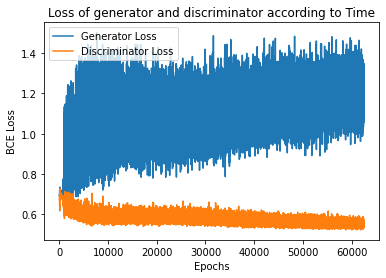

In [18]:
model_GAN.plot_loss()

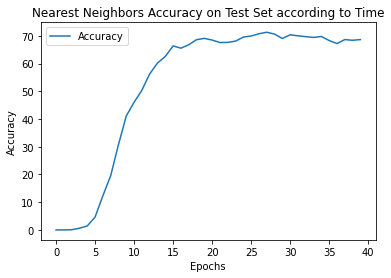

In [19]:
model_GAN.plot_accuracy()

In [20]:
model_GAN.accuracy()

71.29

In [21]:
model_GAN.refine()

Beginning refinement..
Refinement 1
New accuracy : 79.34
Refinement 2
New accuracy : 79.48
Refinement 3
New accuracy : 79.95
Refinement over


In [23]:
from sklearn.manifold import TSNE
def plot_similar_word(idx, model):

    Y = []
    word_labels = []
    for i in idx:
        Y.append(model.test_source_embeddings[i] @ model.best_W)
        word_labels.append(model.df_test[0][i])
    for i in idx:
        Y.append(model.test_target_embeddings[i])
        word_labels.append(model.df_test[1][i])
    print(len(Y))
    tsne_model = TSNE(perplexity=3, n_components=2, init='pca', n_iter=2500, random_state=23)
    Y = tsne_model.fit_transform(Y)

    # find tsne coords for 2 dimensions
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(idx) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()

8


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


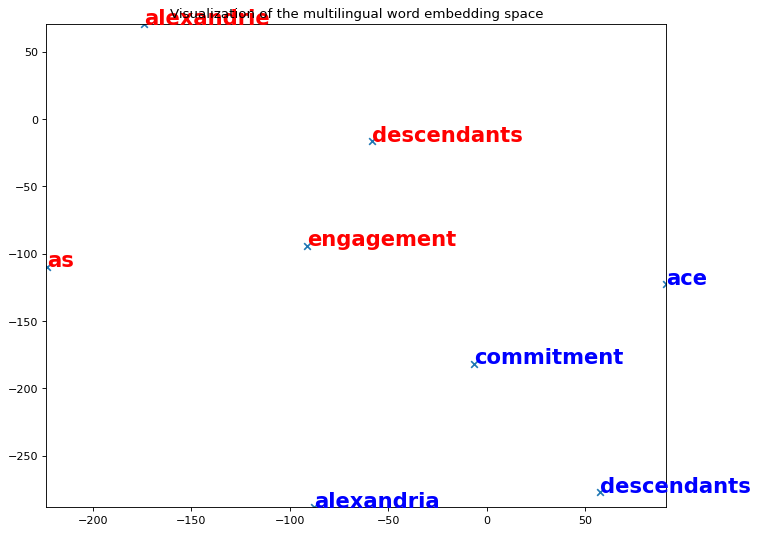

In [24]:
import random
idx = random.sample(range(1,len(model_GAN.test_target_embeddings)), 4)
plot_similar_word(idx, model_GAN)